In [1]:
import sys
sys.path.insert(0, '../')
import sys; sys.argv=['']; del sys

import numpy as np
import os
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

from keras.optimizers import RMSprop, Adam, Nadam
from keras.utils.training_utils import multi_gpu_model
from keras.metrics import top_k_categorical_accuracy, categorical_crossentropy, categorical_accuracy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import GlobalAveragePooling2D, Dense, Input
from keras.models import Model, model_from_json, load_model

Using TensorFlow backend.


In [2]:
RAW = True
if RAW:
    test_filename = 'test_raw.csv'
    data_dir = 'train_sampled_raw'
    from input_data import image_generator_xd_raw as image_generator_xd
    from input_data import df_to_image_array_xd_raw as df_to_image_array_xd
else:
    test_filename = 'test_simplified.csv'
    data_dir = 'train_sampled'
    from input_data import image_generator_xd
    from input_data import df_to_image_array_xd

# Setup

In [3]:
NCSVS = 100
SIZE = 115
BATCHSIZE = 400
BASESIZE = 256
NCATS = 340
IN_CHANNEL = 3
NUM_TOTAL_DATA = int(1020000*0.99)
STEPS = int(NUM_TOTAL_DATA/BATCHSIZE)
EPOCHS = 70
VERBOSE = 1
MODEL_PATH = '/data/doodle/h5'
INPUT_DIR = '/data/doodle/'

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [4]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

# Train full_model

In [5]:
def build_model(keras_model, weights=None):
    model_param = {
        'include_top': False if weights else True,
        'input_shape': (SIZE, SIZE, IN_CHANNEL),
        'weights': weights,
        'classes': None if weights else NCATS
    }
    model = keras_model(**model_param)
    
    if weights:
        print('Adding classification layers')
        op = GlobalAveragePooling2D(name='avg_pool')(model.output)
        output_tensor = Dense(NCATS, activation='softmax', name='predictions')(op)
        model = Model(inputs=model.input, outputs=output_tensor, name=model.name)
    return model

In [6]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception

model = build_model(Xception, weights='imagenet')           # (public/private) = ??
#model = build_model(Xception)                               # (public/private) = (0.93040/0.92964)
#model = build_model(InceptionResNetV2, weights='imagenet')  # (public/private) = (0.92898/0.93034)
#model = build_model(InceptionResNetV2)                      # (public/private) = (0.93123/0.92961)

Adding classification layers


In [7]:
model.summary()
print(len(model.layers))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 115, 115, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 57, 57, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 57, 57, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 57, 57, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [13]:
RETRAIN = True
if RETRAIN:
    model_json_filename = '/data/doodle/h5/xception-115_3_425_0951.json'
    model_h5_filename = '/data/doodle/h5/xception-115_3_425_0951.h5'
    model = loaded_model
    print(model)

In [10]:
random_number = np.random.randint(0, 1000)
model_name = '%s-%d_%d_%d_%04d' % (model.name, SIZE, IN_CHANNEL, BATCHSIZE, random_number)
model_json_filename = os.path.join(MODEL_PATH, model_name + '.json')
model_h5_filename = os.path.join(MODEL_PATH, model_name + '.h5')
print(model_json_filename, model_h5_filename)

/data/doodle/h5/model_1-115_3_400_0395.json /data/doodle/h5/model_1-115_3_400_0395.h5


In [14]:
model_json = model.to_json()
with open(model_json_filename, "w") as json_file:
    json_file.write(model_json)

TypeError: can't pickle _thread.lock objects

In [21]:
try:
    model = multi_gpu_model(model, gpus=2)
    print('used multi-gpu model')
except:
    pass
optimizer_param = {
    'optimizer': Adam(lr=0.002),
    'loss':'categorical_crossentropy',
    'metrics':[categorical_crossentropy, categorical_accuracy, top_3_accuracy],
}
model.compile(**optimizer_param)

used multi-gpu model


In [22]:
train_datagen = image_generator_xd(SIZE, BATCHSIZE, ks=range(NCSVS - 1), time_color=True)
validation_datagen = image_generator_xd(SIZE, BATCHSIZE, ks=range(NCSVS-1, NCSVS))

(400, 115, 115, 3)


'suitcase'

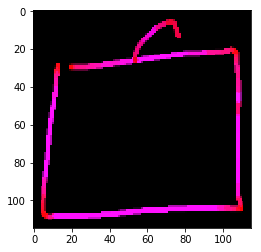

In [23]:
x, y = next(train_datagen)
y = np.argmax(y, axis=1)
print(x.shape)
idx = np.random.randint(0, 255)
tmp_x = x[idx].reshape((SIZE, SIZE, IN_CHANNEL))
plt.imshow(tmp_x)

# label category
cat_dict = list_all_categories()
cat_dict[y[idx]]

(400, 115, 115, 3)


'spider'

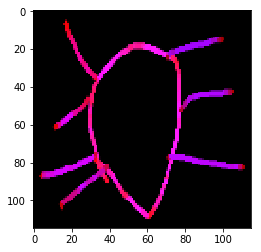

In [24]:
x, y = next(validation_datagen)
y = np.argmax(y, axis=1)
print(x.shape)
idx = np.random.randint(0, 255)
tmp_x = x[idx].reshape((SIZE, SIZE, IN_CHANNEL))
plt.imshow(tmp_x)

# label category
cat_dict = list_all_categories()
cat_dict[y[idx]]

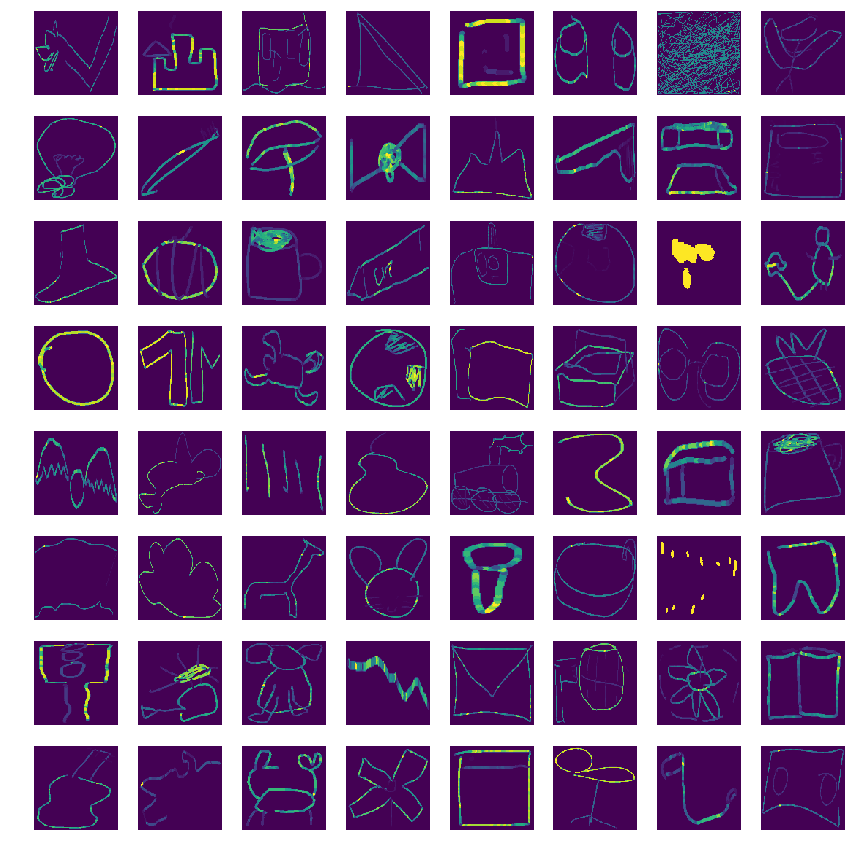

In [25]:
n = 8
layer = 1
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    #a = (-x[i]+1)/2
    a = ax.imshow(x[i, :, :, layer])
    a = ax.axis('off')
plt.tight_layout()

Text(0.5,1,'whole image')

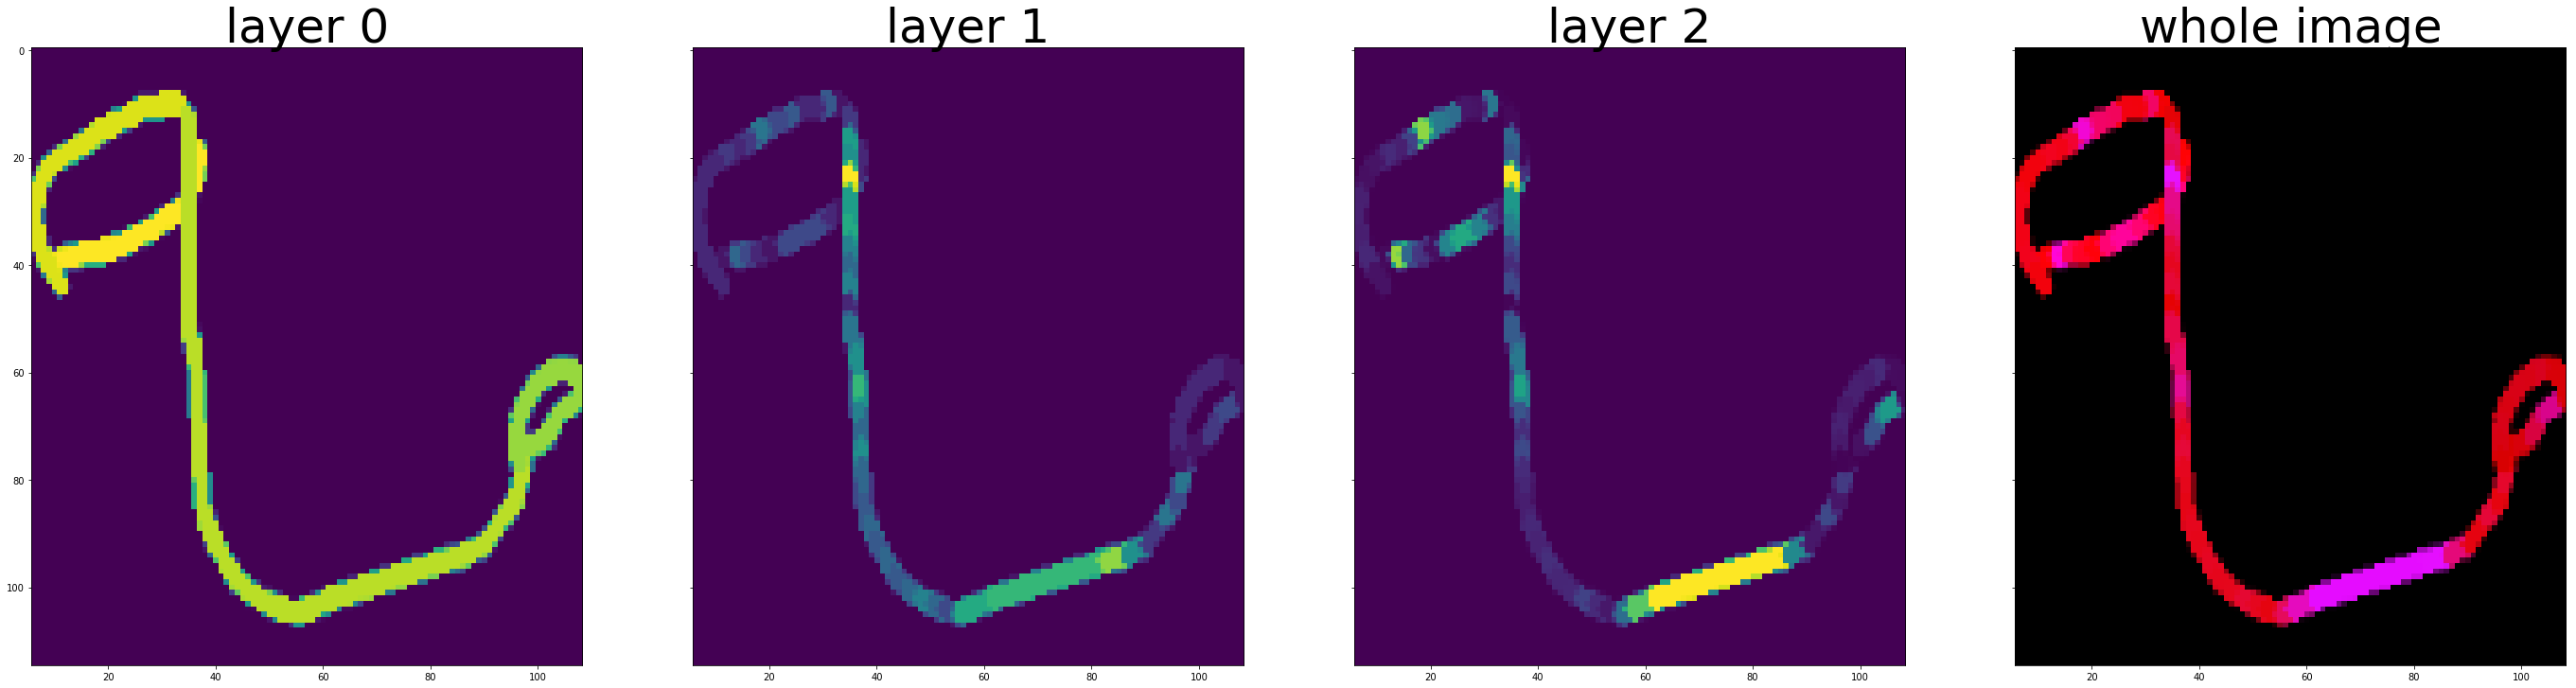

In [26]:
font = {'fontsize':50}
idx = np.random.randint(0, BATCHSIZE)
fig, axs = plt.subplots(1, 4, figsize=(48, 12), sharey=True)
axs[0].imshow(x[idx,:,:,0])
axs[1].imshow(x[idx,:,:,1])
axs[2].imshow(x[idx,:,:,2])
axs[3].imshow(x[idx].reshape((SIZE, SIZE, 3)))

axs[0].set_title('layer 0', fontdict=font)
axs[1].set_title('layer 1', fontdict=font)
axs[2].set_title('layer 2', fontdict=font)
axs[3].set_title('whole image', fontdict=font)

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.75, patience=3, min_delta=0.001,
                          mode='max', min_lr=1e-5, verbose=1),
    ModelCheckpoint(model_h5_filename, monitor='val_top_3_accuracy', mode='max', save_best_only=True,
                    save_weights_only=True),
]

hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=validation_datagen, validation_steps=100,
    callbacks = callbacks
)

Epoch 1/70
2524/2524 [==============================] - 1765s 699ms/step - loss: 0.7486 - categorical_crossentropy: 0.7486 - categorical_accuracy: 0.8025 - top_3_accuracy: 0.9280 - val_loss: 0.7916 - val_categorical_crossentropy: 0.7916 - val_categorical_accuracy: 0.7909 - val_top_3_accuracy: 0.9237
Epoch 2/70
2524/2524 [==============================] - 1746s 692ms/step - loss: 0.7503 - categorical_crossentropy: 0.7503 - categorical_accuracy: 0.8018 - top_3_accuracy: 0.9280 - val_loss: 0.7568 - val_categorical_crossentropy: 0.7568 - val_categorical_accuracy: 0.7993 - val_top_3_accuracy: 0.9278
Epoch 3/70
2524/2524 [==============================] - 1754s 695ms/step - loss: 0.7321 - categorical_crossentropy: 0.7321 - categorical_accuracy: 0.8062 - top_3_accuracy: 0.9302 - val_loss: 0.7442 - val_categorical_crossentropy: 0.7442 - val_categorical_accuracy: 0.8040 - val_top_3_accuracy: 0.9282
Epoch 4/70
2524/2524 [==============================] - 1746s 692ms/step - loss: 0.7303 - categor

In [ ]:
print(model_json_filename, model_h5_filename)

In [27]:
#model.save_weights(model_h5_filename)

# Load full_model

In [6]:
model_json_filename = '/data/doodle/h5/xception-115_3_425_0951.json'
model_h5_filename = '/data/doodle/h5/xception-115_3_425_0951.h5'

json_file = open(model_json_filename, "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
try:
    #1/0
    loaded_model = multi_gpu_model(loaded_model, gpus=2)
except ZeroDivisionError:
    pass

In [7]:
loaded_model.load_weights(model_h5_filename)

In [8]:
loaded_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 115, 115, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 115, 115, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 115, 115, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
xception (Model)                (None, 340)          21558140    lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
__________

In [8]:
test = pd.read_csv('/data/doodle/%s' % test_filename)
test.head()
x_test = df_to_image_array_xd(test, SIZE)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

(112199, 3) (112199, 128, 128, 3)
Test array memory 20.54 GB


In [9]:
test_predictions = loaded_model.predict(x_test, batch_size=128, verbose=1)
top3 = preds2catids(test_predictions)
top3.head()

112199/112199 [==============================] - 250s 2ms/step


,a,b,c
0,234,281,266
1,144,36,125
2,305,62,110
3,187,111,303
4,56,113,112


In [10]:
cat_dict = list_all_categories()
cat_dict = [cat.replace(' ', '_') for cat in cat_dict]

In [11]:
top3.loc[:,'a'] = list(map(lambda x: cat_dict[x], top3.a))
top3.loc[:,'b'] = list(map(lambda x: cat_dict[x], top3.b))
top3.loc[:,'c'] = list(map(lambda x: cat_dict[x], top3.c))

In [12]:
top3.loc[:, 'word'] = [' '.join((a, b, c)) for a, b, c in zip(top3.a, top3.b, top3.c)]

In [13]:
top3.head()

,a,b,c,word
0,radio,stereo,snorkel,radio stereo snorkel
1,hockey_puck,bottlecap,frying_pan,hockey_puck bottlecap frying_pan
2,The_Great_Wall_of_China,castle,fence,The_Great_Wall_of_China castle fence
3,mountain,finger,tent,mountain finger tent
4,campfire,fireplace,fire_hydrant,campfire fireplace fire_hydrant


In [15]:
submission_df = pd.concat([test.key_id, top3.word], axis=1)
submission_df.to_csv('/data/doodle/submission/tmp.csv', index=False)

In [16]:
for i in range(NCATS):
    test.loc[:,'prob_%d' % i] = test_predictions[:,i]

In [17]:
test.drop(columns=['countrycode','drawing'], inplace=True)

In [18]:
test.to_csv('/data/doodle/prob/prob_inception_resnet_v2-128_3_500_0029.csv', index=False)

# Ensemble

In [5]:
import os
import pandas as pd
prob_files = os.listdir('/data/doodle/prob/')
prob_files = list(map(lambda x: '/data/doodle/prob/'+x, prob_files))
prob = np.zeros((112199, 340))
features = ['prob_%d'%i for i in range(NCATS)]
for f in prob_files:
    prob_df = pd.read_csv(f)
    prob += prob_df[features].values
    print('%s were processed' % f)
    key_id = prob_df.key_id
    del prob_df

/data/doodle/prob/prob_xception-115_3_400_0774.csv were processed
/data/doodle/prob/prob_inception_restnet_v2-128_3_500_0803.csv were processed


In [6]:
top3 = preds2catids(prob/2)
top3.head()

,a,b,c
0,234,281,29
1,144,36,125
2,305,62,309
3,187,111,303
4,56,113,112


In [7]:
cat_dict = list_all_categories()
cat_dict = [cat.replace(' ', '_') for cat in cat_dict]

In [8]:
top3.loc[:,'a'] = list(map(lambda x: cat_dict[x], top3.a))
top3.loc[:,'b'] = list(map(lambda x: cat_dict[x], top3.b))
top3.loc[:,'c'] = list(map(lambda x: cat_dict[x], top3.c))

In [9]:
top3.loc[:, 'word'] = [' '.join((a, b, c)) for a, b, c in zip(top3.a, top3.b, top3.c)]
top3.head()

,a,b,c,word
0,radio,stereo,binoculars,radio stereo binoculars
1,hockey_puck,bottlecap,frying_pan,hockey_puck bottlecap frying_pan
2,The_Great_Wall_of_China,castle,toe,The_Great_Wall_of_China castle toe
3,mountain,finger,tent,mountain finger tent
4,campfire,fireplace,fire_hydrant,campfire fireplace fire_hydrant


In [10]:
submission_df = pd.concat([key_id, top3.word], axis=1)
submission_df.to_csv('/data/doodle/submission/ensembled_tmp.csv', index=False)

In [11]:
submission_df.head(3)

,key_id,word
0,9000003627287624,radio stereo binoculars
1,9000010688666847,hockey_puck bottlecap frying_pan
2,9000023642890129,The_Great_Wall_of_China castle toe
